This notebook shows how to use TabPFN for tabular prediction with a scikit learn wrapper.

classifier = TabPFNClassifier(device='cpu')
classifier.fit(train_xs, train_ys)
prediction_ = classifier.predict(test_xs)

The fit function does not perform any computations, but only saves the training data. Computations are only done at inference time, when calling predict.
Note that the presaved models were trained for up to 100 features, 10 classes and 1000 samples. While the model does not have a hard bound on the number of samples, the features and classes are restricted and larger sizes lead to an error.

### Setup

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from tabpfn import TabPFNClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [3]:
base_path = '.'

In [4]:
# 读取数据
train = pd.read_csv('/root/autodl-fs/data/train_revise+45缩减到100特征 数量1000个 去掉三列和Name.csv')  

# 分离特征和标签
X = train.drop(['senolytic'], axis=1)
y = train['senolytic']  

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# 定义模型
models = {
    'TabPFN1': TabPFNClassifier(device='cuda', model_file="/root/autodl-fs/Sq-TabPFN/tabpfn/smote+sq_models_diff/prior_diff_real_checkpoint_n_1_epoch_110.cpkt"),
    'TabPFN2': TabPFNClassifier(device='cuda', model_file="/root/autodl-fs/tabpfn复现模型/models_diff/prior_diff_real_checkpoint_n_1_epoch_70.cpkt"),
    'SVM': SVC(C=100, gamma='scale', kernel='poly'),
    'RandomForest': RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200),
    'XGBoost': xgb.XGBClassifier(colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.8),
    'CatBoost': CatBoostClassifier(depth=6, iterations=100, l2_leaf_reg=3, learning_rate=0.1),
    'LogisticRegression': LogisticRegression(C=1, penalty='l2'),
    'KNN': KNeighborsClassifier(metric='euclidean', n_neighbors=7, weights='distance')
}

# 存储评价指标
results = {}
y_test_bin = label_binarize(y_test, classes=[0, 1])

# 绘制ROC曲线
plt.figure(figsize=(12, 6))
for model_name, model in models.items():
    # 训练模型
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # 检查predict_proba方法是否存在，以便获取概率
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    '''
    # 计算评价指标
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    fpr, tpr, _ = roc_curve(y_test, y_proba)  # 计算假阳性率和真阳性率
    roc_auc = auc(fpr, tpr) 
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    results[model_name] = [accuracy, precision, recall, f1, roc_auc, pr_auc]
    '''
    
    # 计算评价指标
    accuracy = accuracy_score(y_test, y_pred)
    precision_single = precision_score(y_test, y_pred, average='binary')
    recall_single = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    fpr, tpr, _ = roc_curve(y_test, y_proba)  # 计算假阳性率和真阳性率
    roc_auc = auc(fpr, tpr) 
    pr_precision, pr_recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(pr_recall, pr_precision)
    
    # 存储单一数值的指标
    results[model_name] = [accuracy, precision_single, recall_single, f1, roc_auc, pr_auc]

Loading /root/autodl-fs/Sq-TabPFN/tabpfn/smote+sq_models_diff/prior_diff_real_checkpoint_n_1_epoch_110.cpkt
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading /root/autodl-fs/tabpfn复现模型/models_diff/prior_diff_real_checkpoint_n_1_epoch_70.cpkt
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
0:	learn: 0.6378248	total: 55.4ms	remaining: 5.49s
1:	learn: 0.5935819	total: 60ms	remaining: 2.94s
2:	learn: 0.5531907	total: 63.3ms	remaining: 2.05s
3:	learn: 0.5229226	total: 67ms	remaining: 1.61s
4:	learn: 0.4972947	total: 109ms	remaining: 2.07s
5:	learn: 0.4748444	total: 114ms	remaining: 1.78s
6:	learn: 0.4539877	total: 118ms	remaining: 1.57s
7:	learn: 0.4316507	total: 122ms	remaining: 1.4s
8:	learn: 0.4196856	total: 126ms	remaining: 1.28s
9:	learn: 0.4068518	total: 131ms	remaining: 1.18s
10:	learn: 0.3947278	total: 210ms	remaining: 1.7s
11:	learn: 0.3841648	total: 213ms	remaining: 1.56s
12:	learn: 0

/root/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<Figure size 1200x600 with 0 Axes>

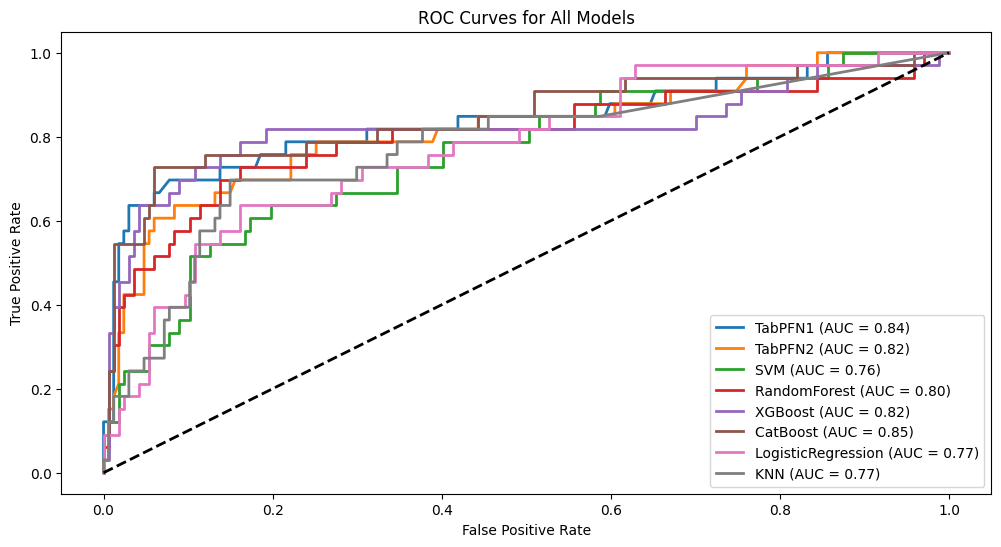

In [6]:
# 绘制ROC曲线
plt.figure(figsize=(12, 6))
for model_name, model in models.items():
    # 检查模型是否有 predict_proba 方法，否则使用 decision_function
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    
    # 如果y_proba不为None，绘制ROC曲线
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)  # 计算假阳性率和真阳性率
        roc_auc = auc(fpr, tpr)                   # 计算AUC
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')  # 绘制曲线

# 添加对角线、标题和标签
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # 对角线表示随机猜测的ROC曲线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.show()

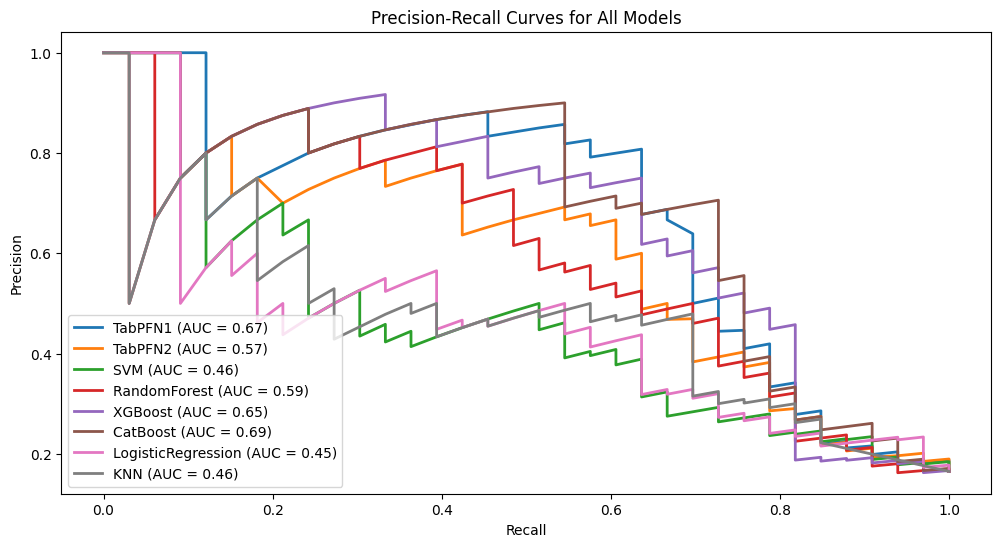

In [7]:
# 绘制PR曲线
plt.figure(figsize=(12, 6))
for model_name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    if y_proba is not None:
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, lw=2, label=f'{model_name} (AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for All Models')
plt.legend(loc='lower left')
plt.show()

In [8]:
# 输出评价指标
metrics_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'roc_auc', 'pr_auc']).T
display(metrics_df)

,Accuracy,Precision,Recall,F1 Score,roc_auc,pr_auc
TabPFN1,0.915,0.807692,0.636364,0.711864,0.838596,0.672598
TabPFN2,0.885,0.678571,0.575758,0.622951,0.817184,0.572304
SVM,0.855,0.700000,0.212121,0.325581,0.757757,0.457253
RandomForest,0.880,0.714286,0.454545,0.555556,0.803302,0.593940
XGBoost,0.900,0.760000,0.575758,0.655172,0.820178,0.648332
CatBoost,0.915,0.900000,0.545455,0.679245,0.847940,0.685082
LogisticRegression,0.845,0.600000,0.181818,0.279070,0.773725,0.454271
KNN,0.835,0.500000,0.363636,0.421053,0.774542,0.460782
